# **Analise de Dados de logistica da empresa Loggi**


___

# Tópicos
___

1. Introdução;
2. Análise Exploratória de Dados;
3. Gerando vizualizações;
4. Insights.

   
# 1 - Introdução
## 1.1 - Sobre a Loggi 

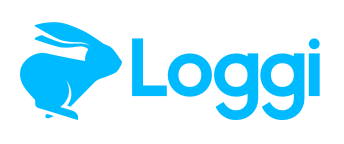

> A Loggi é uma startup unicórnio brasileira de tecnologia focada em logística, avaliada em US$ 1 bilhão, com investimentos de grandes empresas como SoftBank, Microsoft, GGV Capital, Monashees e Kaszek (fonte). Inicialmente, a empresa começou suas operações entregando documentos entre 2013 e 2014. Posteriormente, expandiu seu escopo para o segmento de e-commerce e, desde 2017, tem atuado também nas entregas de alimentos.

## 1.2 - Sobre os Dados

O Loggi Benchmark for Urban Deliveries (BUD) é um repositório no GitHub (link) que disponibiliza dados e códigos relacionados aos desafios comuns enfrentados por empresas de logística. Esses dados são sintetizados a partir de fontes públicas, como IBGE e IPEA, e refletem os desafios enfrentados pela Loggi em sua operação diária, especialmente em relação à escala.

## 1.3 - Sobre o Projeto

Neste projeto, utilizaremos os dados disponibilizados pela Loggi para realizar uma análise profunda e estruturada. O foco será explorar a distribuição dos hubs da empresa no Distrito Federal, visando obter insights valiosos para a empresa. As abordagens incluem:

1. Comparação dos Pontos de Entrega com as Áreas Mais Urbanizadas:** Analisaremos a distribuição dos pontos de entrega em relação às áreas urbanizadas para identificar padrões e oportunidades de otimização.

2. Quantidade de Entregas de Cada Hub:** Investigaremos o volume de entregas gerenciado por cada hub, permitindo uma compreensão detalhada da carga de trabalho de cada unidade.

3. Distância Máxima de Entrega de Cada Hub:** Calcularemos as distâncias máximas de entrega para cada hub, proporcionando uma visão abrangente da cobertura geográfica de cada unidade.

4. Volume dos Pacotes por Hub:** Analisaremos o volume e o tamanho dos pacotes entregues por cada hub, oferecendo insights sobre a natureza dos produtos transportados.



Essas abordagens fornecerão uma análise completa e acionável para a Loggi, permitindo que a empresa tome decisões informadas para aprimorar suas operações de entrega no Distrito Federal.
    


# 2 - Análise Exploratória dos Dados.



## 2.1 - Importando as bibliotecas.

In [ ]:
#Instalando GeoPandas
!pip install geopandas;

In [ ]:
#Importando bibliotecas

import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter

In [ ]:
#Função para calcular Distancia

def calcular_distancia(row):
    hub_coords = (row['hub_lat'], row['hub_lng'])
    entrega_coords = (row['delivery_lat'], row['delivery_lng'])
    return geodesic(hub_coords, entrega_coords).kilometers

##  2.2 - Baixando os arquivos necessários.

In [ ]:
#Download do arquivo deliveries.json, arquivo já modificado pelo Professor André Perez.
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json 

#Download do arquivo deliveries-geodata.csv, para a geração dos pontos de geolocalização.
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv 

#Download do mapa do Distrito Federal direto do site do ibge.
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip

!wget -q "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/2021/Malha_de_setores_(shp)_por_UFs/DF/DF_Setores_2021.zip" 

#Download de mapa do DF com as malhas de organizações regionais

!wget -q "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/2021/Malha_de_setores_(shp)_por_UFs/DF/DF_Setores_2021.zip"


## 2.3 - Exploração dos Dados.

In [ ]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

len(data)

In [ ]:
example = data[0]

print(example.keys())

In [ ]:
example['name']

In [ ]:
example['region']

In [ ]:
example['origin']['lat']

In [ ]:
example['origin']['lng']

In [ ]:
example['vehicle_capacity']

In [ ]:
example['deliveries'][0]['point']['lat']

## 2.4 - Limpeza, Transformação e Estruturação dos Dados.


In [ ]:
deliveries_df = pd.DataFrame(data)
deliveries_df.head()

In [ ]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df.head()

In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

In [ ]:
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.head()

In [ ]:
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df.head()

In [ ]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head()

In [ ]:
#Utilizando a função lambda para "normalizar" os dados sem perder o indice original

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()

In [ ]:
len(deliveries_exploded_df)

In [ ]:
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

**Visualizando como ficou a estrutura dos nossos dados.**

> Após toda a parte de limpeza e estruturação dos dados, vamos ver os resultados.

In [ ]:
len(deliveries_df)

In [ ]:
deliveries_df.shape

In [ ]:
deliveries_df.columns

In [ ]:
deliveries_df.index

In [ ]:
deliveries_df.info()

In [ ]:
deliveries_df.head(n=5)

In [ ]:
deliveries_df.dtypes

In [ ]:
deliveries_df.select_dtypes("object").describe().transpose()

In [ ]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

In [ ]:
deliveries_df.isna().any()

## 2.5 - Geolocalização


## 2.5.1 - Geocodificação Reversa do hub

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

In [ ]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

In [ ]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

In [ ]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

In [ ]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

In [ ]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

## 2.5.2 - Geocodificação Reversa das entregas

In [ ]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

## 2.6 - Verificando a qualidade dos Dados.

In [ ]:
deliveries_df.info()

In [ ]:
deliveries_df.isna().any()

In [ ]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

In [ ]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

In [ ]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

In [ ]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

# 3 - Visualizações

## 3.1 - Gerando a visualização do mapa de entregas/hub do Distrito Federal

In [ ]:
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

In [ ]:
!unzip -q DF_Setores_2021.zip -d ./maps
!cp ./maps/DF_Setores_2021.shp ./DF_Setores_2021.shp
!cp ./maps/DF_Setores_2021.shx ./DF_Setores_2021.shx

mapa_df_regioes = geopandas.read_file('DF_Setores_2021.shp')

In [ ]:
# Criando o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="#A69EBA")

# Plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# Plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# Plot da legenda
plt.title("Entregas no Distrito Federal por Hub's", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])


>Na análise do mapa acima, é evidente que as regiões dos hubs estão bem distribuídas. No entanto, observa-se que a região do hub DF-0 possui uma área de abrangência consideravelmente maior do que os demais hubs.

**Agora vamos comparar o mapa das entregas com o mapa do Distrito Federal dividido por Setores.**


In [ ]:
    
mapa_df_regioes.plot(figsize=((50/2.54, 50/2.54)), facecolor= 'lightgrey', edgecolor= 'black')
plt.title('Distrito Federal - Divisão por Setores')
plt.show()

>Como podemos observar, a distribuição dos pacotes coincide significativamente com os setores mais urbanizados do Distrito Federal. Desta vez, vamos posicionar os pontos das entregas no mapa setorizado.



In [ ]:
# Criando o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Plot mapa do distrito federal
mapa_df_regioes.plot(ax=ax, alpha=0.4, facecolor= 'lightgrey', edgecolor= 'grey')

# Plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# Plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# Plot da legenda
plt.title("Entregas no Distrito Federal por Região no Mapa Setorizado", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

>Agora está mais evidente a correlação entre as áreas mais urbanizadas e as entregas. Vamos agora analisar a frequência de entrega de cada hub.


## 3.2 - Gerando Grafico da quantidade de entregas por Hub.

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.head()

In [ ]:
rotulos = ['48%', '41%', '11%']  

colors = ('Blue','Green','Red')


with sns.axes_style('whitegrid'):
   
    grafico = sns.barplot(data=data, x="region", y="proportion", errorbar=None, palette=colors)
    grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção')
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['0', '10%', '20%', '30%', '40%', '50%'])
    
    for i, p in enumerate(grafico.patches):
        grafico.annotate(rotulos[i], (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                         textcoords='offset points')


plt.show()

>É evidente a disparidade no volume de entregas entre DF-0 e DF-1. Enquanto DF-1 é responsável por aproximadamente 48% das entregas totais no Distrito Federal, o hub DF-0 representa apenas 11% do total de entregas.
No proximo passo, vamos ver qual hub tem a entrega mais distante.


## 3.3 - Gerando Grafico da distância de cada Hub com seu ponto de entrega mais distante.

In [ ]:
geo_deliveries_df['distancia_ao_hub'] = geo_deliveries_df.apply(calcular_distancia, axis=1)

print(geo_deliveries_df)

In [ ]:
distancia_hub = geo_deliveries_df[['region','distancia_ao_hub']].groupby('region').max().reset_index()
print(distancia_hub)

In [ ]:
colors = ('Red','Blue','Green')

with sns.axes_style('whitegrid'):
   
    grafico = sns.barplot(data=distancia_hub, x="region", y="distancia_ao_hub",  palette=colors)
    
    grafico.set(title='Distância Máxima de Entregas por Hub', xlabel='Hub', ylabel='Distância em KM')
     
    
plt.show()

>Apesar de ter um volume consideravelmente menor de entregas, o hub DF-1 tem entregas mais distantes que os outros Hub's.
Desta vez vamos ver se há alguma diferença no tamanho das encomendas por região, pois talvez compense usar veículos maiores ou menores dependendo do fluxo de entregas e tamanho dos pacotes.</span>

## 3.4 - Gerando Grafico da quantidade de entregas separada por tamanho dos pacotes

In [ ]:
size = pd.DataFrame(deliveries_df[['region', 'delivery_size']])
size.head(100)

In [ ]:
size_df0 = size[size['region'] == 'df-0']['delivery_size']
size_df1 = size[size['region'] == 'df-1']['delivery_size']
size_df2 = size[size['region'] == 'df-2']['delivery_size']

size_delivery0 = size_df0.value_counts()
size_delivery1 = size_df1.value_counts()
size_delivery2 = size_df2.value_counts()
print(size_delivery0,size_delivery1,size_delivery2)

In [ ]:
colors = ('Red', 'Blue', 'Green')

tamanhos = range(1, 11)
frequencias_df0 = [size_delivery0.get(tamanho, 0) for tamanho in tamanhos]
frequencias_df1 = [size_delivery1.get(tamanho, 0) for tamanho in tamanhos]
frequencias_df2 = [size_delivery2.get(tamanho, 0) for tamanho in tamanhos]

largura_barra = 0.2

plt.figure(figsize=(10, 6))
plt.bar([tamanho - largura_barra for tamanho in tamanhos], frequencias_df0, largura_barra, label='df-0', color=colors[0])
plt.bar(tamanhos, frequencias_df1, largura_barra, label='df-1', color=colors[1])
plt.bar([tamanho + largura_barra for tamanho in tamanhos], frequencias_df2, largura_barra, label='df-2', color=colors[2])

plt.xlabel('Tamanho de Entrega')
plt.ylabel('Frequência')
plt.title('Frequência dos Tamanhos de Entrega por Região')

plt.xticks(tamanhos)

plt.legend()
plt.show()

> Nítidamente não há nenhuma disparidade nesta abordagem, o tamanho dos pacotes são equivalentes, se medirmos proporcionalmente ao fluxo de entrega de cada Hub.

# 4 - Insights

1. Ao observarmos as entregas no mapa do Distrito Federal, dividido por setores, torna-se claro que o grande volume de entregas está concentrado nos centros urbanos.

2. Também é perceptível que enquanto os hubs DF-1 e DF-2 têm um alto volume de entregas, o hub DF-0 representa apenas 11% da demanda.

3. No entanto, a área territorial que o hub DF-0 abrange é consideravelmente maior do que os demais. Ao analisarmos a distância do hub até sua entrega mais distante, o hub DF-0 possui uma entrega a aproximadamente 69 km de distância, enquanto os hubs DF-2 e DF-1 têm entregas a uma distância máxima de 33.5 km e 39.5 km, respectivamente.

4. Também buscamos comparar o tamanho das entregas de cada região, porém não encontramos nenhuma discrepância significativa quando comparado proporcionalmente ao volume de entregas de cada hub.

5. Considerando os dados, todos os hubs têm a mesma capacidade de entrega em termos de volume de veículos, e se a capacidade de armazenamento for equivalente, seria interessante considerar um remanejamento de parte do hall de entregas do hub DF-1 para o hub DF-0. A demanda de entrega do hub DF-0 representa menos de 1/4 do volume de entregas do hub DF-1 . Além disso, é importante levar em consideração que, apesar das distâncias das entregas do hub DF-0 serem maiores, ele atende principalmente regiões rurais, o que geralmente resulta em menos tráfego nas vias.



